## **Imports**

In [40]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm



## **Preprocessing**

In [6]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [7]:
original_path = r"E:\chest_xray"
save_path = r"E:\preprocessed_dataset"

img_size = (224, 224)

transform = A.Compose([
    A.Resize(height=img_size[0], width=img_size[1]),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
])

for mode in ['train', 'test']:
    for label in ['NORMAL', 'PNEUMONIA']:
        os.makedirs(os.path.join(save_path, mode, label), exist_ok=True)

def preprocess_images(data_type):
    for label in ['NORMAL', 'PNEUMONIA']:
        src_folder = os.path.join(original_path, data_type, label)
        tgt_folder = os.path.join(save_path, data_type, label)

        for img_name in tqdm(os.listdir(src_folder), desc=f'Processing {data_type}/{label}'):
            img_path = os.path.join(src_folder, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Skipping unreadable image: {img_name}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            augmented = transform(image=img)
            img = augmented['image']

            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  

            img = img.astype('float32') / 255.0  

            save_img_path = os.path.join(tgt_folder, img_name)
            cv2.imwrite(save_img_path, (img * 255).astype('uint8'))  

preprocess_images('train')
preprocess_images('test')

c:\Users\yosef\anaconda3\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
Processing test/PNEUMONIA: 100%|██████████| 390/390 [00:03<00:00, 127.94it/s]


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [12]:
train_dir = r"E:\preprocessed_dataset\train"
test_dir = r"E:\preprocessed_dataset\test"

In [13]:
data_path = r"E:\preprocessed_dataset"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.BCEWithLogitsLoss()
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-4
PATIENCE = 5
best_val_acc = 0.0
patience_counter = 0

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(os.path.join(data_path, "train"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_path, "test"), transform=transform)

# Split training into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print("Train:", Counter([label for _, label in train_dataset]))
print("Test :", Counter([label for _, label in test_dataset]))
print("Val :", Counter([label for _, label in val_subset]))


Train: Counter({1: 3883, 0: 1349})
Test : Counter({1: 390, 0: 234})
Val : Counter({1: 780, 0: 267})


## **Special Training Function**

In [27]:
import torch
from torch.optim import Adam
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer=None, scheduler=None,
                device='cpu', epochs=10, patience=5, save_path='best_model.pth', lr=1e-4):
    if optimizer is None:
        optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    if scheduler is None:
        from torch.optim.lr_scheduler import StepLR
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds = torch.sigmoid(outputs) > 0.5
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    model.load_state_dict(torch.load(save_path))
    return 

## **Test Function**

In [42]:
def evaluate_model(model, model_path, test_loader, criterion, device):
    try:
        model.load_state_dict(torch.load(model_path))
    except Exception as e:
        raise ValueError(f"Error loading model from {model_path}: {str(e)}")
    
    model = model.to(device)
    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    wrong_predictions = []

    with torch.no_grad():
        loop = tqdm(test_loader, desc="Testing", leave=False)
        for batch_idx, (images, labels) in enumerate(loop):
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)  
            predicted = (probs > 0.5).float()  

            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            predicted = predicted.squeeze(1).long()  
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.squeeze(1).long().cpu().numpy())

            for i in range(len(labels)):
                if predicted[i] != labels[i].long():
                    wrong_predictions.append({
                        "batch_index": batch_idx,
                        "image_index": i,
                        "true_label": labels[i].item(),
                        "predicted_label": predicted[i].item(),
                        "probability": probs[i].item() if predicted[i] == 1 else 1 - probs[i].item()  
                    })

    test_loss /= test_total
    test_acc = test_correct / test_total

    class_report = classification_report(all_labels, all_preds, target_names=["NORMAL", "PNEUMONIA"])
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"\nFinal Test Loss: {test_loss:.4f} | Final Test Accuracy: {test_acc:.4f}")
    print("\nClassification Report:")
    print(class_report)

    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Get the name of the model class
    model_name = model.__class__.__name__

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'{model_name} - Confusion Matrix')  
    plt.show()

    return test_loss, test_acc, all_preds, all_labels

## **ResNet50 Model**

In [44]:
resnet50_model = models.resnet50(pretrained=True)

for param in resnet50_model.parameters():
    param.requires_grad = False

for name, param in resnet50_model.layer4.named_parameters():
    param.requires_grad = True
for name, param in resnet50_model.named_parameters():
    if 'bn' in name and 'layer4' in name:
        param.requires_grad = True

num_features = resnet50_model.fc.in_features
resnet50_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 1)
)

resnet50_model = resnet50_model.to(device)

c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 1.Train the model

In [65]:
train_model(resnet50_model, train_loader, val_loader, criterion, device=device,
            epochs=EPOCHS, patience=PATIENCE, save_path='Best_resnet50.pth')

Epoch [1/30] | Train Loss: 0.1566 | Train Acc: 0.9355 | Val Loss: 0.0754 | Val Acc: 0.9656


Epoch [2/30] | Train Loss: 0.0354 | Train Acc: 0.9890 | Val Loss: 0.0930 | Val Acc: 0.9675


Epoch [3/30] | Train Loss: 0.0176 | Train Acc: 0.9938 | Val Loss: 0.0669 | Val Acc: 0.9733


Epoch [4/30] | Train Loss: 0.0117 | Train Acc: 0.9957 | Val Loss: 0.0720 | Val Acc: 0.9752


Epoch [5/30] | Train Loss: 0.0138 | Train Acc: 0.9959 | Val Loss: 0.0684 | Val Acc: 0.9761


Epoch [6/30] | Train Loss: 0.0082 | Train Acc: 0.9974 | Val Loss: 0.0633 | Val Acc: 0.9819


Epoch [7/30] | Train Loss: 0.0039 | Train Acc: 0.9998 | Val Loss: 0.0691 | Val Acc: 0.9819


Epoch [8/30] | Train Loss: 0.0033 | Train Acc: 0.9993 | Val Loss: 0.0651 | Val Acc: 0.9809


Epoch [9/30] | Train Loss: 0.0026 | Train Acc: 1.0000 | Val Loss: 0.0678 | Val Acc: 0.9790


Epoch [10/30] | Train Loss: 0.0023 | Train Acc: 0.9998 | Val Loss: 0.0664 | Val Acc: 0.9809


Epoch [11/30] | Train Loss: 0.0019 | Train Acc: 0.9998 | Val Loss: 0.0688 | Val Acc: 0.9790
Early stopping triggered.


### 2.Evaluate the model on the test data


Final Test Loss: 0.3947 | Final Test Accuracy: 0.8814

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.69      0.81       234
   PNEUMONIA       0.84      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.92      0.84      0.86       624
weighted avg       0.90      0.88      0.88       624


Confusion Matrix:
[[162  72]
 [  2 388]]


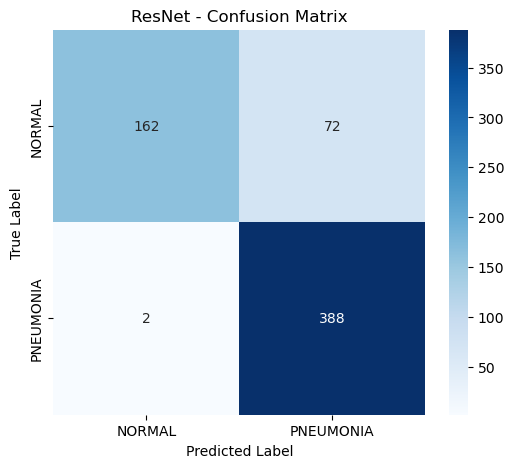

In [45]:
test_loss, test_acc, all_preds, all_labels = evaluate_model(resnet50_model,'Best_resnet50.pth', test_loader, criterion, device)

## **MobileNet Model**

In [46]:
mobilenet_model = models.mobilenet_v3_small(pretrained=True)

for param in mobilenet_model.parameters():
    param.requires_grad = False

for name, param in mobilenet_model.features[11:13].named_parameters():
    param.requires_grad = True
for name, param in mobilenet_model.features[10].named_parameters():
    if 'bn' in name:
        param.requires_grad = True

num_features = mobilenet_model.classifier[0].in_features
mobilenet_model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 1)
)

mobilenet_model = mobilenet_model.to(device)

c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 1.Train MobileNet Model 

In [32]:
train_model(mobilenet_model, train_loader, val_loader, criterion, device=device,
            epochs=EPOCHS, patience=PATIENCE, save_path='Best_mobilenet.pth')


Epoch [1/30] | Train Loss: 0.3705 | Train Acc: 0.8459 | Val Loss: 0.4293 | Val Acc: 0.7755


Epoch [2/30] | Train Loss: 0.1767 | Train Acc: 0.9484 | Val Loss: 0.6159 | Val Acc: 0.7526


Epoch [3/30] | Train Loss: 0.1246 | Train Acc: 0.9601 | Val Loss: 0.6607 | Val Acc: 0.7507


Epoch [4/30] | Train Loss: 0.1038 | Train Acc: 0.9661 | Val Loss: 0.6318 | Val Acc: 0.7727


Epoch [5/30] | Train Loss: 0.0847 | Train Acc: 0.9716 | Val Loss: 0.1845 | Val Acc: 0.9226


Epoch [6/30] | Train Loss: 0.0770 | Train Acc: 0.9742 | Val Loss: 0.1065 | Val Acc: 0.9580


Epoch [7/30] | Train Loss: 0.0708 | Train Acc: 0.9749 | Val Loss: 0.1043 | Val Acc: 0.9589


Epoch [8/30] | Train Loss: 0.0768 | Train Acc: 0.9720 | Val Loss: 0.0935 | Val Acc: 0.9656


Epoch [9/30] | Train Loss: 0.0699 | Train Acc: 0.9754 | Val Loss: 0.0873 | Val Acc: 0.9685


Epoch [10/30] | Train Loss: 0.0670 | Train Acc: 0.9785 | Val Loss: 0.0861 | Val Acc: 0.9675


Epoch [11/30] | Train Loss: 0.0686 | Train Acc: 0.9759 | Val Loss: 0.0857 | Val Acc: 0.9685


Epoch [12/30] | Train Loss: 0.0665 | Train Acc: 0.9778 | Val Loss: 0.0856 | Val Acc: 0.9666


Epoch [13/30] | Train Loss: 0.0678 | Train Acc: 0.9763 | Val Loss: 0.0851 | Val Acc: 0.9675


Epoch [14/30] | Train Loss: 0.0659 | Train Acc: 0.9756 | Val Loss: 0.0852 | Val Acc: 0.9675
Early stopping triggered.


### 2.Test The MobileNet Model


Final Test Loss: 0.3010 | Final Test Accuracy: 0.8718

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.68      0.80       234
   PNEUMONIA       0.84      0.99      0.91       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.89      0.87      0.87       624


Confusion Matrix:
[[159  75]
 [  5 385]]


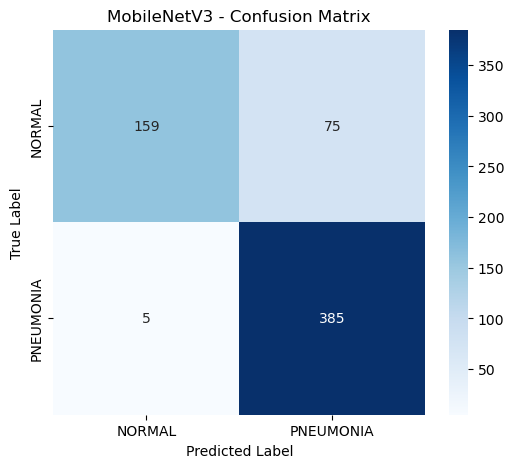

In [47]:
test_loss, test_acc, all_preds, all_labels = evaluate_model(mobilenet_model, 'Best_mobilenet.pth', test_loader, criterion, device)

## **DenseNet121**

In [48]:
import torch.nn as nn
from torchvision import models

densenet_model = models.densenet121(pretrained=True)

for param in densenet_model.parameters():
    param.requires_grad = False

for name, param in densenet_model.features.denseblock4.named_parameters():
    param.requires_grad = True
for name, param in densenet_model.features.norm5.named_parameters():
    param.requires_grad = True

num_features = densenet_model.classifier.in_features
densenet_model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 1)
)

densenet_model = densenet_model.to(device)


c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 1.Train Densenet121

In [60]:
train_model(densenet_model, train_loader, val_loader, criterion, device=device,
            epochs=EPOCHS, patience=PATIENCE, save_path='best_densenet_model.pth')

Epoch [1/30] | Train Loss: 0.2437 | Train Acc: 0.9054 | Val Loss: 0.1155 | Val Acc: 0.9608


Epoch [2/30] | Train Loss: 0.0947 | Train Acc: 0.9656 | Val Loss: 0.0832 | Val Acc: 0.9694


Epoch [3/30] | Train Loss: 0.0468 | Train Acc: 0.9881 | Val Loss: 0.0808 | Val Acc: 0.9733


Epoch [4/30] | Train Loss: 0.0261 | Train Acc: 0.9952 | Val Loss: 0.0711 | Val Acc: 0.9752


Epoch [5/30] | Train Loss: 0.0148 | Train Acc: 0.9971 | Val Loss: 0.0705 | Val Acc: 0.9780


Epoch [6/30] | Train Loss: 0.0106 | Train Acc: 0.9981 | Val Loss: 0.0704 | Val Acc: 0.9771


Epoch [7/30] | Train Loss: 0.0129 | Train Acc: 0.9974 | Val Loss: 0.0694 | Val Acc: 0.9761


Epoch [8/30] | Train Loss: 0.0080 | Train Acc: 0.9995 | Val Loss: 0.0701 | Val Acc: 0.9761


Epoch [9/30] | Train Loss: 0.0096 | Train Acc: 0.9990 | Val Loss: 0.0718 | Val Acc: 0.9761


Epoch [10/30] | Train Loss: 0.0092 | Train Acc: 0.9986 | Val Loss: 0.0719 | Val Acc: 0.9771
Early stopping triggered.


### 2.Test Densenet121


Final Test Loss: 0.3012 | Final Test Accuracy: 0.8910

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.73      0.83       234
   PNEUMONIA       0.86      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624


Confusion Matrix:
[[170  64]
 [  4 386]]


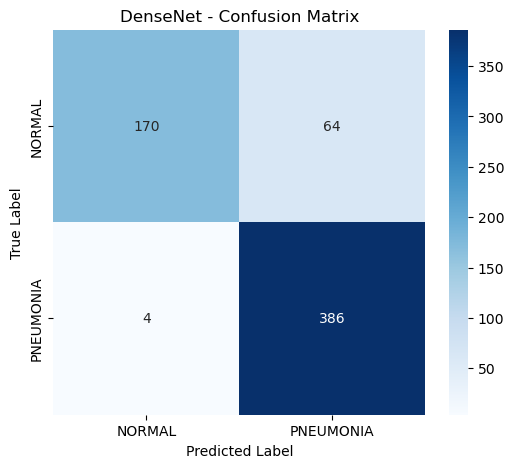

In [49]:
test_loss, test_acc, all_preds, all_labels = evaluate_model(densenet_model,'best_densenet_model.pth', test_loader, criterion, device)

## **EfficientNet_b0**

In [50]:
efficientnet_model = models.efficientnet_b0(pretrained=True)

for param in efficientnet_model.parameters():
    param.requires_grad = False

for name, param in efficientnet_model.features[-2:].named_parameters():
    param.requires_grad = True

num_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(num_features, 1)
)

efficientnet_model = efficientnet_model.to(device)

c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 1.Train EfficientNetB0

In [76]:
train_model(efficientnet_model, train_loader, val_loader, criterion, device=device,
            epochs=EPOCHS, patience=PATIENCE, save_path='best_efficientnet_model.pth')

Epoch [1/30] | Train Loss: 0.3488 | Train Acc: 0.8793 | Val Loss: 0.1935 | Val Acc: 0.9303


Epoch [2/30] | Train Loss: 0.1614 | Train Acc: 0.9462 | Val Loss: 0.1305 | Val Acc: 0.9542


Epoch [3/30] | Train Loss: 0.1275 | Train Acc: 0.9524 | Val Loss: 0.1158 | Val Acc: 0.9589


Epoch [4/30] | Train Loss: 0.0939 | Train Acc: 0.9689 | Val Loss: 0.1116 | Val Acc: 0.9618


Epoch [5/30] | Train Loss: 0.0787 | Train Acc: 0.9720 | Val Loss: 0.1085 | Val Acc: 0.9618


Epoch [6/30] | Train Loss: 0.0725 | Train Acc: 0.9775 | Val Loss: 0.1075 | Val Acc: 0.9599


Epoch [7/30] | Train Loss: 0.0726 | Train Acc: 0.9768 | Val Loss: 0.1046 | Val Acc: 0.9599


Epoch [8/30] | Train Loss: 0.0730 | Train Acc: 0.9780 | Val Loss: 0.1064 | Val Acc: 0.9618


Epoch [9/30] | Train Loss: 0.0731 | Train Acc: 0.9742 | Val Loss: 0.1056 | Val Acc: 0.9608
Early stopping triggered.


### 2.Test EfficientNetB0


Final Test Loss: 0.3300 | Final Test Accuracy: 0.8910

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.74      0.84       234
   PNEUMONIA       0.86      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624


Confusion Matrix:
[[173  61]
 [  7 383]]


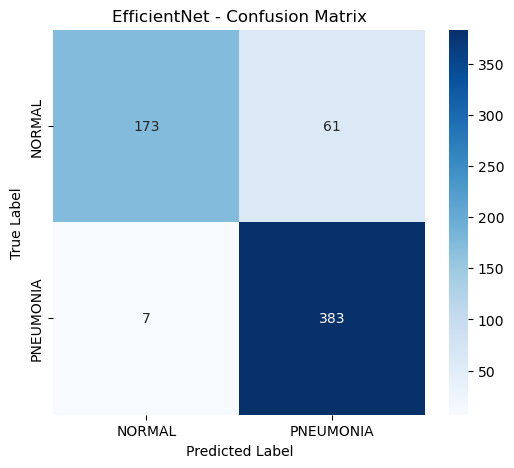

In [51]:
test_loss, test_acc, all_preds, all_labels = evaluate_model(efficientnet_model, 'best_efficientnet_model.pth', test_loader, criterion, device)

## **ResNet34**

In [52]:
resnet_model = models.resnet34(pretrained=True)

for param in resnet_model.parameters():
    param.requires_grad = False

for name, param in resnet_model.layer4.named_parameters():
    param.requires_grad = True
for name, param in resnet_model.fc.named_parameters():
    param.requires_grad = True

num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 1)
)

resnet_model = resnet_model.to(device)

c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 1.Train ResNet34

In [79]:
train_model(resnet_model, train_loader, val_loader, criterion, device=device,
            epochs=EPOCHS, patience=PATIENCE, save_path='best_resnet34_model.pth')

Epoch [1/30] | Train Loss: 0.1580 | Train Acc: 0.9438 | Val Loss: 0.0808 | Val Acc: 0.9666


Epoch [2/30] | Train Loss: 0.0467 | Train Acc: 0.9838 | Val Loss: 0.0625 | Val Acc: 0.9761


Epoch [3/30] | Train Loss: 0.0380 | Train Acc: 0.9869 | Val Loss: 0.0556 | Val Acc: 0.9838


Epoch [4/30] | Train Loss: 0.0102 | Train Acc: 0.9988 | Val Loss: 0.0554 | Val Acc: 0.9828


Epoch [5/30] | Train Loss: 0.0136 | Train Acc: 0.9964 | Val Loss: 0.0555 | Val Acc: 0.9828


Epoch [6/30] | Train Loss: 0.0085 | Train Acc: 0.9983 | Val Loss: 0.0457 | Val Acc: 0.9847


Epoch [7/30] | Train Loss: 0.0053 | Train Acc: 0.9995 | Val Loss: 0.0451 | Val Acc: 0.9847


Epoch [8/30] | Train Loss: 0.0042 | Train Acc: 0.9995 | Val Loss: 0.0450 | Val Acc: 0.9857


Epoch [9/30] | Train Loss: 0.0049 | Train Acc: 0.9990 | Val Loss: 0.0444 | Val Acc: 0.9847


Epoch [10/30] | Train Loss: 0.0048 | Train Acc: 0.9993 | Val Loss: 0.0448 | Val Acc: 0.9857


Epoch [11/30] | Train Loss: 0.0037 | Train Acc: 0.9998 | Val Loss: 0.0447 | Val Acc: 0.9847


Epoch [12/30] | Train Loss: 0.0032 | Train Acc: 0.9998 | Val Loss: 0.0438 | Val Acc: 0.9847


Epoch [13/30] | Train Loss: 0.0032 | Train Acc: 0.9998 | Val Loss: 0.0456 | Val Acc: 0.9857
Early stopping triggered.


### 2.Test ResNet34


Final Test Loss: 0.4194 | Final Test Accuracy: 0.8718

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.67      0.80       234
   PNEUMONIA       0.83      0.99      0.91       390

    accuracy                           0.87       624
   macro avg       0.91      0.83      0.85       624
weighted avg       0.89      0.87      0.87       624


Confusion Matrix:
[[157  77]
 [  3 387]]


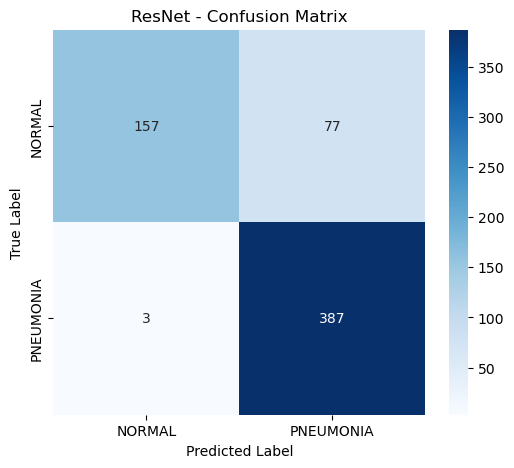

In [53]:
test_loss, test_acc, all_preds, all_labels = evaluate_model(resnet_model, 'best_resnet34_model.pth', test_loader, criterion, device)

## **VGG16**

In [54]:
vgg_model = models.vgg16_bn(pretrained=True)

for param in vgg_model.parameters():
    param.requires_grad = False

for name, param in vgg_model.features[24:].named_parameters():
    param.requires_grad = True
for name, param in vgg_model.classifier[6:].named_parameters():
    param.requires_grad = True

num_features = vgg_model.classifier[6].in_features
vgg_model.classifier[6] = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 1)
)

vgg_model = vgg_model.to(device)

c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 1.Train VGG16

In [82]:
train_model(vgg_model, train_loader, val_loader, criterion, device=device,
            epochs=EPOCHS, patience=PATIENCE, save_path='best_vgg16_model.pth')

Epoch [1/30] | Train Loss: 0.1687 | Train Acc: 0.9326 | Val Loss: 0.0495 | Val Acc: 0.9819


Epoch [2/30] | Train Loss: 0.0424 | Train Acc: 0.9871 | Val Loss: 0.0613 | Val Acc: 0.9780


Epoch [3/30] | Train Loss: 0.0227 | Train Acc: 0.9914 | Val Loss: 0.0574 | Val Acc: 0.9819


Epoch [4/30] | Train Loss: 0.0126 | Train Acc: 0.9957 | Val Loss: 0.0685 | Val Acc: 0.9780


Epoch [5/30] | Train Loss: 0.0097 | Train Acc: 0.9971 | Val Loss: 0.0884 | Val Acc: 0.9790


Epoch [6/30] | Train Loss: 0.0034 | Train Acc: 0.9990 | Val Loss: 0.0770 | Val Acc: 0.9809
Early stopping triggered.


### 2.Test VGG16


Final Test Loss: 0.3099 | Final Test Accuracy: 0.8878

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.71      0.83       234
   PNEUMONIA       0.85      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.85      0.87       624
weighted avg       0.90      0.89      0.88       624


Confusion Matrix:
[[167  67]
 [  3 387]]


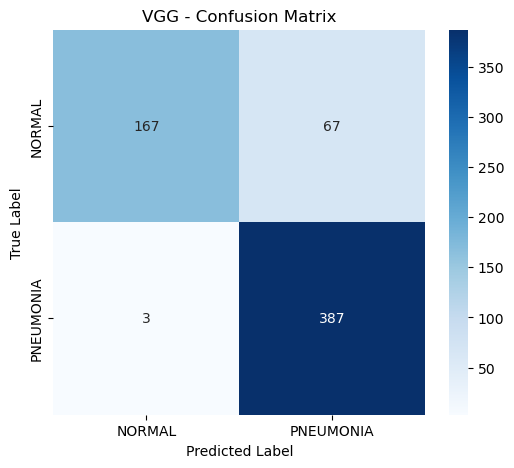

In [55]:
test_loss, test_acc, all_preds, all_labels = evaluate_model(vgg_model, 'best_vgg16_model.pth', test_loader, criterion, device)

## **EnsembleModel using some previous models**

## **load the models & get the predictions**

In [34]:
def load_densenet():
    model = models.densenet121(pretrained=False)
    model.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(model.classifier.in_features, 1))
    model.load_state_dict(torch.load('best_densenet_model.pth', map_location=device))
    return model.to(device).eval()

def load_mobilenet():
    model = models.mobilenet_v3_small(pretrained=False)
    model.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(model.classifier[0].in_features, 1))
    model.load_state_dict(torch.load('Best_mobilenet.pth', map_location=device))
    return model.to(device).eval()

def load_efficientnet():
    model = models.efficientnet_b0(pretrained=False)
    model.classifier = nn.Sequential(nn.Dropout(0.4), nn.Linear(model.classifier[1].in_features, 1))
    model.load_state_dict(torch.load('best_efficientnet_model.pth', map_location=device))
    return model.to(device).eval()

def load_vgg():
    model = models.vgg16_bn(pretrained=False)
    model.classifier[6] = nn.Sequential(nn.Dropout(0.5), nn.Linear(model.classifier[6].in_features, 1))
    model.load_state_dict(torch.load('best_vgg16_model.pth', map_location=device))
    return model.to(device).eval()

## **Ensemble Voting Hard & Soft**

In [83]:
def ensemble_voting(models, dataloader):
    all_soft_preds = []
    all_hard_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            batch_preds = []

            for model in models:
                outputs = model(images)
                probs = torch.sigmoid(outputs).squeeze(1)
                batch_preds.append(probs.cpu().numpy())

            batch_preds = np.stack(batch_preds, axis=0)
            soft_avg = np.mean(batch_preds, axis=0)
            hard_votes = np.round(batch_preds)
            hard_majority = np.round(np.mean(hard_votes, axis=0))

            all_soft_preds.extend((soft_avg > 0.9).astype(int))
            all_hard_preds.extend(hard_majority.astype(int))
            all_labels.extend(labels.numpy())

    return all_labels, all_soft_preds, all_hard_preds


In [84]:
models_list = [
    load_densenet(),
    load_mobilenet(),
    load_efficientnet(),
    load_vgg()
]

labels, soft_preds, hard_preds = ensemble_voting(models_list, test_loader)


c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yosef\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Soft Voting Results:
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.95      0.94       234
   PNEUMONIA       0.97      0.95      0.96       390

    accuracy                           0.95       624
   macro avg       0.95      0.95      0.95       624
weighted avg       0.95      0.95      0.95       624

Confusion Matrix:
[[222  12]
 [ 18 372]]


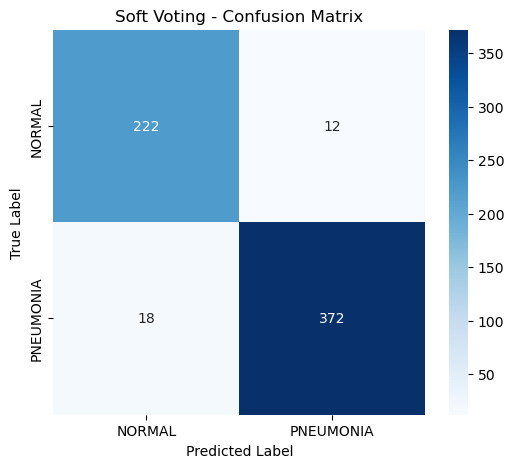


Hard Voting Results:
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.78      0.86       234
   PNEUMONIA       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.90       624
weighted avg       0.91      0.91      0.90       624

Confusion Matrix:
[[182  52]
 [  6 384]]


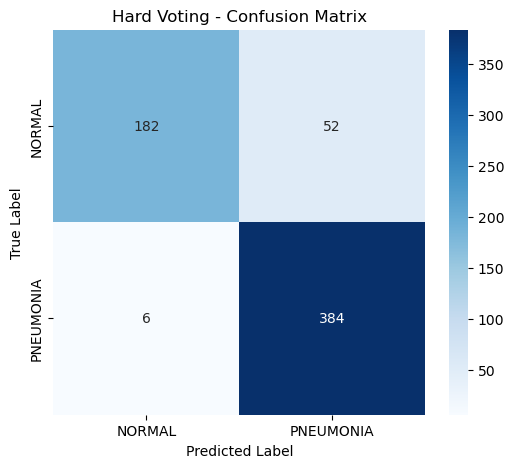

In [85]:
def evaluate(true_labels, predicted_labels, name=""):
    print(f"\n{name} Voting Results:")

    class_report = classification_report(true_labels, predicted_labels, target_names=["NORMAL", "PNEUMONIA"])
    print("Classification Report:")
    print(class_report)

    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'{name} Voting - Confusion Matrix')
    plt.show()
evaluate(labels, soft_preds, name="Soft")
evaluate(labels, hard_preds, name="Hard")